# Bandlimited Angular Spectrum (BLAS)

Example of ["Band-Limited Angular Spectrum Method for Numerical Simulation of Free-Space Propagation in Far and Near Fields"](https://opg.optica.org/oe/fulltext.cfm?uri=oe-17-22-19662&id=186848) (2010) by Matsushima and Shimobaba.

In this example, we replicate Fig 9(a) from the paper, namely propagating a rectangular aperture.

In [1]:
from functools import partial
import numpy as np
import chromatix.functional as cf
import matplotlib.pyplot as plt

Let's first define the setup as in the paper. We chose the wavelength to be 532 microns. All units are in microns.

In [2]:
shape = (1024, 1024)
N_pad = (512, 512)  # padding to linearize the FFT
spectrum = 0.532    # wavelength
dxi = 2 * spectrum
D = dxi * shape[0]  # field shape
w = D / 2           # width of aperture
z = 100 * D         # propagation distance
dxi = D / np.array(shape)
spacing = dxi[..., np.newaxis]
n = 1  # refractive index of medium
gpu_device = 0

print("Field shape [um]: ", D)
print("Width of aperture [um]: ", w)
print("Propagation distance [um]: ", z)

Field shape [um]:  1089.536
Width of aperture [um]:  544.768
Propagation distance [um]:  108953.6


Let's create a rectangular aperture at the input.

2024-05-28 08:52:41.936303: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


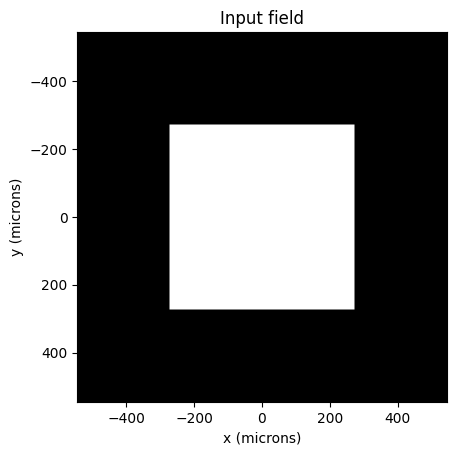

In [3]:
from jax import device_put
import jax

field = cf.plane_wave(
    shape=shape,
    dx=spacing, 
    spectrum=spectrum, 
    spectral_density=1.0, 
    pupil=partial(cf.square_pupil, w=w)
)
field = device_put(field, jax.devices()[gpu_device])  
plt.imshow(
    field.amplitude.squeeze(), 
    cmap='gray',
    extent=[
        -D/2, D/2,   # x-axis
        D/2, -D/2]   # y-axis
)
plt.title("Input field")
plt.ylabel("y (microns)")
plt.xlabel("x (microns)");

And now we propagate! With and without bandlimiting. By default ``bandlimit=False``.

In [4]:
# Angular spectrum
out_field_asm = cf.asm_propagate(field, z, n, N_pad=N_pad, mode="same", bandlimit=False)
u_asm = out_field_asm.amplitude.squeeze()

# Angular spectrum (bandlimited)
out_field_blas = cf.asm_propagate(field, z, n, N_pad=N_pad, mode="same", bandlimit=True)
u_blas = out_field_blas.amplitude.squeeze()

Now let's plot to see how bandlimiting removes the high frequency noise due to aliasing.

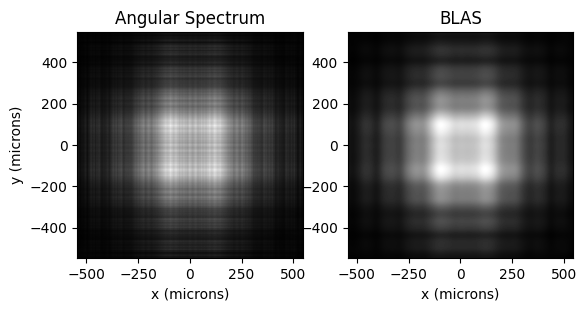

In [5]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(
    u_asm, 
    cmap='gray',
    extent=[-D/2, D/2, -D/2, D/2]
)
axs[0].set_title("Angular Spectrum")
axs[0].set_ylabel("y (microns)")
axs[0].set_xlabel("x (microns)")
axs[1].imshow(
    u_blas, 
    cmap='gray',
    extent=[-D/2, D/2, -D/2, D/2]
)
axs[1].set_title("BLAS")
axs[1].set_xlabel("x (microns)");


# Off-axis

Below we see how to propagate off-axis, namely shift the destination plane as in [this paper](https://opg.optica.org/oe/fulltext.cfm?uri=oe-18-17-18453&id=205150).
This can reduce the FFT size if one is interested in the field off-axis

Let's shift by half the aperture width along the x-axis.

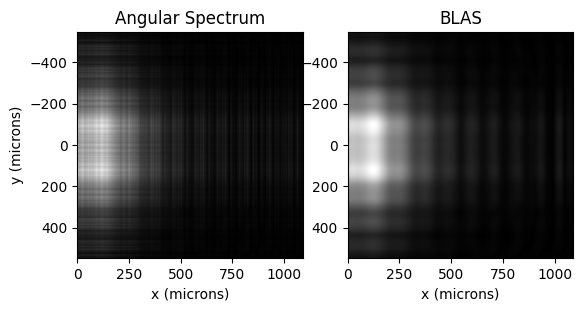

In [6]:
shift_yx = (0, D/2)

extent = [   # for plotting
    -D/2 + shift_yx[1], D/2 + shift_yx[1],
    D/2 + shift_yx[0], -D/2 + shift_yx[0]
]

# Angular spectrum
out_field_asm = cf.asm_propagate(
    field, z, n, N_pad=N_pad, mode="same", bandlimit=False, shift_yx=shift_yx
)
u_asm = out_field_asm.amplitude.squeeze()

# Angular spectrum (bandlimited)
out_field_blas = cf.asm_propagate(
    field, z, n, N_pad=N_pad, mode="same", bandlimit=True, shift_yx=shift_yx
)
u_blas = out_field_blas.amplitude.squeeze()

# plot
fig, axs = plt.subplots(1, 2)
axs[0].imshow(u_asm, cmap='gray', extent=extent)
axs[0].set_title("Angular Spectrum")
axs[0].set_ylabel("y (microns)")
axs[0].set_xlabel("x (microns)")
axs[1].imshow(u_blas, cmap='gray', extent=extent)
axs[1].set_title("BLAS")
axs[1].set_xlabel("x (microns)");

Let's tilt the illumination and shift off-axis.

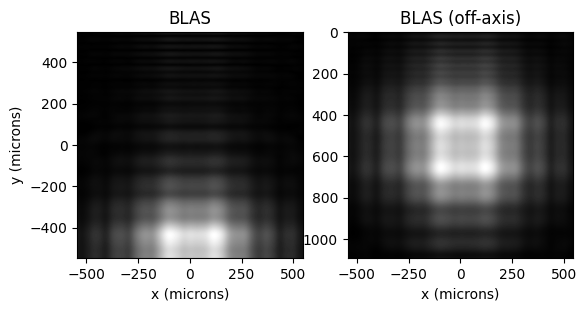

In [7]:
kykx = (-5/w, 0)
shift_yx = (D/2, 0)   # to better center according to tilt

# Angular spectrum
out_blas = cf.asm_propagate(
    field, z, n, N_pad=N_pad, mode="same", bandlimit=True, kykx=kykx
)
u_blas = out_blas.amplitude.squeeze()

# Angular spectrum (bandlimited)
out_blas_off_axis = cf.asm_propagate(
    field, z, n, N_pad=N_pad, mode="same", bandlimit=True, shift_yx=shift_yx, kykx=kykx
)
u_blas_off_axis = out_blas_off_axis.amplitude.squeeze()

# plot
fig, axs = plt.subplots(1, 2)
axs[0].imshow(u_blas, cmap='gray', extent=[-D/2, D/2, -D/2, D/2])
axs[0].set_title("BLAS")
axs[0].set_ylabel("y (microns)")
axs[0].set_xlabel("x (microns)")
axs[1].imshow(
    u_blas_off_axis, 
    cmap='gray', 
    extent=[   # for plotting
        -D/2 + shift_yx[1], D/2 + shift_yx[1],
        D/2 + shift_yx[0], -D/2 + shift_yx[0]
    ]
)
axs[1].set_title("BLAS (off-axis)")
axs[1].set_xlabel("x (microns)");